In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torch.utils.data as data
from torch.autograd import Variable

import torchvision.datasets as dsets

import numpy as np
import cv2

import os
import struct
import copy
import random

import time
import datetime

import math

from PIL import Image
import torchvision.transforms as transforms
from torchvision.transforms import Compose, ToTensor, Resize
from torch.utils import data
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
%matplotlib inline

### Step 1. Load the dataset

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

class YoloDataset(data.Dataset):
    def __init__(self, root, list_file, train, transform=None):
        self.image_size = 448
        self.root = root
        self.train = train
        self.transform = transform
        self.fnames = []
        self.boxes = []
        self.labels = []
        self.color_jitter = Compose([transforms.ColorJitter(brightness=0.1,contrast=0.1, saturation=0.1, hue=0.1),
                                                 transforms.ToTensor()])
        self.plain = Compose([transforms.ToTensor()])
        self.resize = Compose([transforms.ToPILImage(),
                              transforms.Resize((self.image_size, self.image_size)),
                              transforms.ToTensor()])
        
        with open(list_file) as f:
            lines = f.readlines()
            
        for line in lines:
            splited = line.strip().split()
            self.fnames.append(splited[0])
            num_boxes = (len(splited) - 1) // 5
            box = []
            label = []
            for i in range(num_boxes):
                x_min = float(splited[1+5*i])
                y_min = float(splited[2+5*i])
                x_max = float(splited[3+5*i])
                y_max = float(splited[4+5*i])
                c = splited[5+5*i]
                box.append([x_min, y_min, x_max, y_max])
                label.append(int(c)+1)
            self.boxes.append(torch.Tensor(box))
            self.labels.append(torch.LongTensor(label))
        self.num_samples = len(self.boxes)
        
    def img_pre_process(self, img, boxes, labels):
        
        if random.random() < 0.5:
            im_lr = np.fliplr(img).copy()
            height, width, c = img.shape
            x_min = width - boxes[:, 2]
            x_max = width - boxes[:, 0]
            boxes[:,0] = x_min
            boxes[:,2] = x_max
            img = im_lr
        
        ## Converting the image and box information scaling
        if random.random() < 0.5:
            scale = random.uniform(0.8, 1.2)
            height, width, c = img.shape
            img = cv2.resize(img, (int(width * scale), height))
            boxes = boxes * torch.FloatTensor([[scale, 1, scale, 1]]).expand_as(boxes)
            
        ## Image translation
        if random.random() < 0.5:
            center = (boxes[:,2:] + boxes[:,:2]) / 2
            height, width, c = img.shape
            shifted_img = np.zeros((height, width, c), dtype=img.dtype)
            
            w_range = int(random.uniform(-width*0.2, width*0.2))
            h_range = int(random.uniform(-height*0.2, height*0.2))
            
            if w_range<0 and h_range<0:
                shifted_img[:height+h_range,:width+w_range,:] = img[-h_range:,-w_range:,:]
                
            elif w_range<0 and h_range>=0:
                shifted_img[h_range:,:width+w_range,:] = img[:height-h_range,-w_range:,:]
            
            elif w_range>=0 and h_range>=0:
                shifted_img[h_range:,w_range:,:] = img[:height-h_range,:width-w_range,:]
                
            elif w_range>=0 and h_range<0:
                shifted_img[:height+h_range,w_range:,:] = img[-h_range:,:width-w_range,:]
                
            wh_range = torch.FloatTensor([[w_range, h_range]]).expand_as(center)
            center = center + wh_range
            
            mask1 = (center[:,0] > 0) & (center[:,0] < width)
            mask2 = (center[:,1] > 0) & (center[:,1] < height)
            mask = (mask1 & mask2).view(-1,1)
            
            boxes_in = boxes[mask.expand_as(boxes)].view(-1,4)
            
            if len(boxes_in) != 0:
                box_shift = torch.FloatTensor([[w_range, h_range, w_range, h_range]]).expand_as(boxes_in)
                boxes_in = boxes_in + box_shift
                
                labels_in = labels[mask.view(-1)]
                labels = labels_in
                img = shifted_img
                boxes = boxes_in
        
        ## Image cropping
        if random.random() < 0.5:
            center = (boxes[:,2:] + boxes[:,:2]) / 2
            height, width, c = img.shape
            h = int(random.uniform(0.6*height,height))
            w = int(random.uniform(0.6*width,width))
            x = int(random.uniform(0,width-w))
            y = int(random.uniform(0,height-h))
            
            center = center - torch.FloatTensor([[x, y]]).expand_as(center)
            mask1 = (center[:,0]>0) & (center[:,0]<w)
            mask2 = (center[:,1]>0) & (center[:,1]<h)
            mask = (mask1 & mask2).view(-1, 1)
            
            boxes_in = boxes[mask.expand_as(boxes)].view(-1,4)
            
            if (len(boxes_in)!=0):
                box_shift = torch.FloatTensor([x,y,x,y]).expand_as(boxes_in)

                boxes_in = boxes_in - box_shift
                boxes_in[:,0]=boxes_in[:,0].clamp_(min=0,max=w)
                boxes_in[:,2]=boxes_in[:,2].clamp_(min=0,max=w)
                boxes_in[:,1]=boxes_in[:,1].clamp_(min=0,max=h)
                boxes_in[:,3]=boxes_in[:,3].clamp_(min=0,max=h)

                labels = labels[mask.view(-1)]
                img_cropped = img[y:y+h, x:x+w, :]
                boxes = boxes_in
                img = img_cropped
        
        return img, boxes, labels

    def generate_target(self, img, boxes, labels):
        
        grid_size = 7
        h,w,_ = img.shape
        boxes /= torch.Tensor([w,h,w,h]).expand_as(boxes) # Converting the box size 0 ~ 1
    
        target = torch.zeros((grid_size, grid_size, 30)) 

        cell_size = 1./grid_size 

        wh = boxes[:,2:] - boxes[:,:2]

        cxcy = (boxes[:,2:] + boxes[:,:2]) / 2

        for i in range(cxcy.size()[0]):
            cxcy_sample = cxcy[i] # center pixel 
            ij = (cxcy_sample/cell_size).ceil()-1 
            target[int(ij[1]),int(ij[0]),4] = 1
            target[int(ij[1]),int(ij[0]),9] = 1
            target[int(ij[1]),int(ij[0]),int(labels[i])+9] = 1
            xy = ij*cell_size 
            delta_xy = (cxcy_sample -xy)/cell_size # Converting delta_xy to the size 
                                                   # relative to the bounds of the grid cell
            target[int(ij[1]),int(ij[0]),2:4] = wh[i]
            target[int(ij[1]),int(ij[0]),:2] = delta_xy
            target[int(ij[1]),int(ij[0]),7:9] = wh[i]
            target[int(ij[1]),int(ij[0]),5:7] = delta_xy
            
        return target
    
    def RandomBrightness(self,bgr):
        if random.random() < 0.5:
            hsv = cv2.cvtColor(bgr,cv2.COLOR_BGR2HSV)
            h,s,v = cv2.split(hsv)
            adjust = random.choice([0.5,1.5])
            v = v*adjust
            v = np.clip(v, 0, 255).astype(hsv.dtype)
            hsv = cv2.merge((h,s,v))
            bgr = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)
        return bgr
    def RandomSaturation(self,bgr):
        if random.random() < 0.5:
            hsv = cv2.cvtColor(bgr,cv2.COLOR_BGR2HSV)
            h,s,v = cv2.split(hsv)
            adjust = random.choice([0.5,1.5])
            s = s*adjust
            s = np.clip(s, 0, 255).astype(hsv.dtype)
            hsv = cv2.merge((h,s,v))
            bgr = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)
        return bgr
    def RandomHue(self,bgr):
        if random.random() < 0.5:
            hsv = cv2.cvtColor(bgr,cv2.COLOR_BGR2HSV)
            h,s,v = cv2.split(hsv)
            adjust = random.choice([0.5,1.5])
            h = h*adjust
            h = np.clip(h, 0, 255).astype(hsv.dtype)
            hsv = cv2.merge((h,s,v))
            bgr = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)
        return bgr

    def randomBlur(self,bgr):
        if random.random()<0.5:
            bgr = cv2.blur(bgr,(5,5))
        return bgr
        
    def __getitem__(self, idx):
        fname = self.fnames[idx]
        img = cv2.imread(os.path.join(self.root+fname))
        boxes = self.boxes[idx].clone()
        labels = self.labels[idx].clone()

        if self.train:
            img = self.randomBlur(img)
            img = self.RandomBrightness(img)
            img = self.RandomHue(img)
            img = self.RandomSaturation(img)
            img, boxes, labels = self.img_pre_process(img, boxes, labels)
            
        target = self.generate_target(img, boxes, labels) # 7x7x30
        
        # Image processing
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        img = self.plain(img)
        img = self.resize(img)
        img = 2 * img - 1
        
        return img, target
    
    def __len__(self):
        return self.num_samples
            

### Step 2. Build the YOLO network

In [4]:
class YOLO(nn.Module):
    def __init__(self):
        super(YOLO, self).__init__()
        
        self.pre_train_net = nn.Sequential(
            nn.Conv2d(3, 64, 7, stride=2, padding=3),
            nn.LeakyReLU(negative_slope=0.1),
            nn.MaxPool2d(2,2),
            nn.Conv2d(64, 192, 3, stride=1, padding=1),
            nn.LeakyReLU(negative_slope=0.1),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(192, 128, 1, stride=1, padding=0),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Conv2d(128, 256, 3, stride=1, padding=1),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Conv2d(256, 256, 1, stride=1, padding=0),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Conv2d(256, 512, 3, stride=1, padding=1),
            nn.LeakyReLU(negative_slope=0.1),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(512, 256, 1, stride=1, padding=0),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Conv2d(256, 512, 3, stride=1, padding=1),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Conv2d(512, 256, 1, stride=1, padding=0),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Conv2d(256, 512, 3, stride=1, padding=1),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Conv2d(512, 256, 1, stride=1, padding=0),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Conv2d(256, 512, 3, stride=1, padding=1),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Conv2d(512, 256, 1, stride=1, padding=0),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Conv2d(256, 512, 3, stride=1, padding=1),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Conv2d(512, 512, 1, stride=1, padding=0),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Conv2d(512, 1024, 3, stride=1, padding=1),
            nn.LeakyReLU(negative_slope=0.1),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(1024, 512, 1, stride=1, padding=0),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Conv2d(512, 1024, 3, stride=1, padding=1),
            nn.LeakyReLU(negative_slope=0.1)
        )
        
        self.post_net = nn.Sequential(
            nn.Conv2d(1024, 1024, 3, stride=1, padding=1),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Conv2d(1024, 1024, 3, stride=2, padding=1),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Conv2d(1024, 1024, 3, stride=1, padding=1),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Conv2d(1024, 1024, 3, stride=1, padding=1),
            nn.LeakyReLU(negative_slope=0.01),
            
        )
        
        self.FC1 = nn.Sequential(
            nn.Linear(50176, 4096),
            nn.LeakyReLU(),
            nn.Dropout()
        )
        
        self.FC2 = nn.Sequential(
            nn.Linear(4096, 1470)
        )
        
        self.pre_train_net.cuda()
        self.post_net.cuda()
        self.FC1.cuda()
        self.FC2.cuda()
        
        self._initialize_weights()

    def forward(self, x):
        output = self.pre_train_net(x)
        output = self.post_net(output)

        # Ready to going for FC layer
        output = output.view(output.size(0), -1)

        output = self.FC1(output)
        output = self.FC2(output)

        output = output.view(output.size(0), 7, 7, 30)
        # Converting the output shape to the (batch_size, 7, 7, 30)
        output = F.relu(output)

        return output
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()

### Step 3. Loss function 

In [5]:
class yoloLoss(nn.Module):
    def __init__(self,l_coord,l_noobj):
        super(yoloLoss,self).__init__()
        self.l_coord = l_coord
        self.l_noobj = l_noobj
    
    def compute_prob_error(self, pred, target): ## classification error
        contain = target[:,:,:,4] > 0 # [Batch_size, 7, 7, 1] 
        contain = contain.unsqueeze(3).expand_as(target) # [Batch_size, 7, 7, 30]
        
        coord_pred = pred[contain].view(-1, 30)  # Get cells which contain objects. [n_coord, N]
        class_pred = coord_pred[:, 10:]          # Index 10~29: Probability
        
        coord_target = target[contain].view(-1, 30)
        class_target = coord_target[:, 10:]
        
        prob_loss = F.mse_loss(class_pred, class_target, reduction='sum')
        
        return prob_loss
    
    def not_contain_obj_error(self, pred, target): ## Error where no object appears in cell
        not_contain = target[:,:,:,4] == 0 # [Batch_size, 7, 7, 1]
        not_contain = not_contain.unsqueeze(3).expand_as(target) # [Batch_size, 7, 7, 30]
        
        noobj_pred = pred[not_contain].view(-1, 30)     # Get cells which doesn't contain objects. [n_noobj, N]
        noobj_target = target[not_contain].view(-1, 30)
        
        # To get confidence value, make noobj_conf_mask, confidence index is 4 and 9
        conf_mask = torch.cuda.ByteTensor(noobj_pred.size()).fill_(0) # [n_noobj, N]
        for b in range(2):
            conf_mask[:, 4 + b*5] = 1 # noobj_conf_mask[:, 4] = 1; noobj_conf_mask[:, 9] = 1
        
        noobj_pred_conf = noobj_pred[conf_mask]       # [n_noobj, 2]
        noobj_target_conf = noobj_target[conf_mask]   # [n_noobj, 2]
        noobj_loss1 = F.mse_loss(noobj_pred_conf, noobj_target_conf, reduction='sum')
        
        return noobj_loss1
    
    
    def contain_obj_error(self, pred, target): ##
        contain = target[:,:,:,4] > 0 # [Batch_size, 7, 7, 1]
        contain = contain.unsqueeze(3).expand_as(target) # [Batch_size, 7, 7, 30]
        
        contain_pred = pred[contain].contiguous().view(-1,30) # Only cell which contains the object are remained
        box_pred = contain_pred[:,:10].contiguous().view(-1,5) # Reshaping
        
        contain_target = target[contain].contiguous().view(-1,30)
        box_target = contain_target[:,:10].contiguous().view(-1,5)
        
        # Note that, We assign one predictor to be "responsible" for predicting 
        # an object based on which prediction has the highest current IOU with the ground truth
        # Then, other prediction is "not responsible" for predicting an object
        # That component is included in "contain_noobj_mask variables
        
        contain_obj_mask = torch.cuda.ByteTensor(box_target.size()).zero_() # Create the mask
        contain_noobj_mask = torch.cuda.ByteTensor(box_target.size()).zero_() 
        target_iou_gt = torch.zeros(box_target[:,0].size()).cuda() # In order to save the IoU for confidence 
                                                                   # of the cell which contains object

        for i in range(0, box_target.size()[0], 2):
            box_p = box_pred[i:i+2] # For 2 bounding boxes information
            box_p_coord = Variable(torch.FloatTensor(box_p.size())) # Box coordinate (x_min, y_min, x_max, y_max)
            box_p_coord[:,:2] = box_p[:, :2]/float(7) - 0.5 * box_p[:, 2:4] 
            box_p_coord[:,2:4] = box_p[:, :2]/float(7) + 0.5 * box_p[:, 2:4]

            
            box_t = box_target[i].contiguous().view(-1,5)
            box_t_coord = Variable(torch.FloatTensor(box_t.size()))
            box_t_coord[:,:2] = box_t[:, :2]/float(7) - 0.5 * box_t[:, 2:4] 
            box_t_coord[:,2:4] = box_t[:, :2]/float(7) + 0.5 * box_t[:, 2:4]
            
            iou = self.compute_iou(box_p_coord[:,:4], box_t_coord[:,:4]) # [2,]
                                                      # compute IoU between prediction and target boxes, 
            
            gt_iou, max_idx = iou.max(0)
            contain_obj_mask[i+max_idx] = 1
            contain_noobj_mask[i+1-max_idx] = 1
            
            target_iou_gt[i+max_idx] = gt_iou.data.cuda()
            
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        target_iou_gt = target_iou_gt.to(device)

        ## For the cell which contains object
        contain_box_pred = box_pred[contain_obj_mask].view(-1, 5)
        
        ## For the cell which does not contain object
        not_contain_box_pred = box_pred[contain_noobj_mask].view(-1, 5)

        ## For target domain 
        contain_box_target = box_target[contain_obj_mask].view(-1, 5)
        not_contain_box_target = box_target[contain_noobj_mask].view(-1, 5)
        not_contain_box_target[:,4] = 0
        
        ## For the GT IoU 
        contain_iou_target = target_iou_gt[contain_obj_mask[:,0]] # target_iou_gt size is same to box_target[:,0], so use mask[:, 0]
        
        obj_loss = F.mse_loss(contain_box_pred[:,4], contain_iou_target, size_average=False)
        xy_loss = F.mse_loss(contain_box_pred[:,:2], contain_box_target[:,:2], size_average=False)
        wh_loss = F.mse_loss(torch.sqrt(contain_box_pred[:,2:4]), torch.sqrt(contain_box_target[:,2:4]), size_average=False)
        noobj_loss2 = F.mse_loss(not_contain_box_pred[:,4], not_contain_box_target[:,4], size_average=False)
        
        return obj_loss, xy_loss, wh_loss, noobj_loss2
        
    def compute_iou(self, box_p, box_t):
        
        pred_area = (box_p[:,2] - box_p[:,0]) * (box_p[:,3] - box_p[:,1]) # [2,]
        target_area = (box_t[:,2] - box_t[:,0]) * (box_t[:,3] - box_t[:,1]) #[1,]
        
        box_p = box_p.unsqueeze(1).expand(2,1,4)
        box_t = box_t.unsqueeze(0).expand(2,1,4)
        
        inter_lt = torch.max(box_p[:,:,:2], box_t[:,:,:2]) # [2,1,2]
        
        inter_rb = torch.min(box_p[:,:,2:], box_t[:,:,2:]) # [2,1,2]
        
        wh = inter_rb - inter_lt # [2,1,2]
        wh[wh<0] = 0 
        
        inter_area = wh[:,:,0] * wh[:,:,1] # [2,1]
        pred_area = pred_area.unsqueeze(1).expand_as(inter_area)
        target_area = target_area.unsqueeze(0).expand_as(inter_area)
        
        iou = inter_area / (pred_area + target_area - inter_area)
        
        return iou
    
        
    
    def forward(self,pred,target):

        batch_size = pred.size()[0]
        
        noobj_loss1 = self.not_contain_obj_error(pred, target)
        prob_loss = self.compute_prob_error(pred, target)
        obj_loss, xy_loss, wh_loss, noobj_loss2 = self.contain_obj_error(pred, target)
        
        total_loss = (self.l_coord*(xy_loss + wh_loss) + obj_loss + self.l_noobj*(noobj_loss1 + noobj_loss2) + prob_loss)
        
        return total_loss / batch_size
        
        

### Step 4. Train the model

In [6]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [7]:
file_root = 'dataset/lab8/all_img/'
train_dataset = YoloDataset(root=file_root, list_file='codes_util/lab8/Generate_dataset/voc2007+2012.txt', train=True)
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=4)

model = YOLO()
state_dict = torch.load('pretrain/lab8/pre_train.pt')
model.load_state_dict(state_dict['state_dict'])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

learning_rate = 1e-4
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)
optimizer.load_state_dict(state_dict['optimizer'])

print('pre_train_complete')
criterion = yoloLoss(l_coord=5,l_noobj=0.5)

best = 1e+30
num_epochs = 15
print("training start!")

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
        
    for i, (images, target) in enumerate(train_loader):
        images = images.to(device)
        target = target.to(device)
        
        pred = model(images)
        loss = criterion(pred, target)
        
        total_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 10 == 0:
            print('Epoch [%d/%d], Iter [%d,%d] Loss:%.4f, average_loss: %.4f' % (epoch+1, num_epochs, i+1, len(train_loader), loss.item(), total_loss / (i+1)))


pre_train_complete
training start!
Epoch [1/15], Iter [10,430] Loss:0.8417, average_loss: 1.0656
Epoch [1/15], Iter [20,430] Loss:1.6961, average_loss: 1.0368
Epoch [1/15], Iter [30,430] Loss:0.8254, average_loss: 0.9670
Epoch [1/15], Iter [40,430] Loss:0.6656, average_loss: 0.9145
Epoch [1/15], Iter [50,430] Loss:0.6679, average_loss: 0.8744
Epoch [1/15], Iter [60,430] Loss:0.3806, average_loss: 0.8473
Epoch [1/15], Iter [70,430] Loss:0.5348, average_loss: 0.8496
Epoch [1/15], Iter [80,430] Loss:0.8876, average_loss: 0.8550
Epoch [1/15], Iter [90,430] Loss:1.0174, average_loss: 0.8455
Epoch [1/15], Iter [100,430] Loss:0.8080, average_loss: 0.8476
Epoch [1/15], Iter [110,430] Loss:0.7055, average_loss: 0.8388
Epoch [1/15], Iter [120,430] Loss:0.5430, average_loss: 0.8349
Epoch [1/15], Iter [130,430] Loss:0.3118, average_loss: 0.8319
Epoch [1/15], Iter [140,430] Loss:1.1418, average_loss: 0.8262
Epoch [1/15], Iter [150,430] Loss:0.5191, average_loss: 0.8320
Epoch [1/15], Iter [160,430] 

### Step 5. Inference

### Step 5-1. Inference (Visualizing)

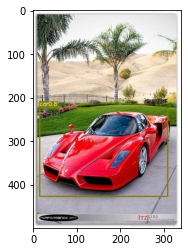

In [8]:
## Visualizing the bouding box image
from codes_util.lab8.util import *

SMALL_VOC_CLASSES = ('aeroplane', 'bicycle', 'bus', 'car', 'cat', 'dog')

Color = [[0, 0, 0],
        [128, 0, 0],
        [0, 128, 0],
        [128, 128, 0],
        [0, 0, 128],
        [128, 0, 128]]

def visualize(model, path):
    result = []
    image = cv2.imread(path)
    h, w, _ = image.shape
    img = cv2.resize(image, (448, 448))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    transform = transforms.Compose([transforms.ToTensor(),])
    img = 2 * transform(img) - 1
    img = Variable(img[None,:,:,:],volatile=True)
    img = img.cuda()
    
    pred = model(img) #1x7x7x30
    pred = pred.cpu()
    boxes,cls_indexs,probs =  interpret_target(pred, 0.1)
    
    for i, box in enumerate(boxes):
        
        x1 = max(int(box[0] * w), 0)
        x2 = min(int(box[2] * w), w)
        y1 = max(int(box[1] * h), 0)
        y2 = min(int(box[3] * h), h)
        cls_index = cls_indexs[i]
        cls_index = int(cls_index)
        prob = probs[i]
        prob = float(prob)
        result.append([(x1, y1), (x2, y2), SMALL_VOC_CLASSES[cls_index], prob])
        
    img = np.zeros((h, w, 3), np.uint8)
    img = img + image[:,:,::-1]
        
    for left_up,right_bottom,class_name,prob in result:
        color = Color[SMALL_VOC_CLASSES.index(class_name)]
        cv2.rectangle(img, left_up, right_bottom, color, 2)
        label = class_name+str(round(prob,2))
        text_size, baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1)
        p1 = (left_up[0], left_up[1]- text_size[1])
        cv2.rectangle(img, (p1[0] - 2//2, p1[1] - 2 - baseline), (p1[0] + text_size[0], p1[1] + text_size[1]), color, -1)
        cv2.putText(img, label, (p1[0], p1[1] + baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, 8)
    
    plt.imshow(img)
    
model.eval()
visualize(model, 'codes_util/lab8/Generate_dataset/images/003033.jpg')

### Step 6-2. Inference (mAP)

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

SMALL_VOC_CLASSES = ('aeroplane', 'bicycle', 'bus', 'car', 'cat', 'dog')

def write(model, path):
    result = []
    image = cv2.imread(path)
    h, w, _ = image.shape
    img = cv2.resize(image, (448, 448))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    transform = transforms.Compose([transforms.ToTensor(),])
    img = 2 * transform(img) - 1
    img = Variable(img[None,:,:,:],volatile=True)
    img = img.cuda()
    
    pred = model(img) #1x7x7x30
    pred = pred.cpu()
    boxes,cls_indexs,probs =  interpret_target(pred, 0)
    
    txt_file = open('codes_util/lab8/Generate_dataset/predicted/'+os.path.basename(path)[:-4]+'.txt', 'w')
    
    for i, box in enumerate(boxes):
        
        x1 = max(int(box[0] * w), 0)
        x2 = min(int(box[2] * w), w)
        y1 = max(int(box[1] * h), 0)
        y2 = min(int(box[3] * h), h)
        cls_index = cls_indexs[i]
        cls_index = int(cls_index)
        prob = probs[i]
        prob = float(prob)
        txt_file.write(str(SMALL_VOC_CLASSES[cls_index])+' '+'%.6f'%(prob)+' '+str(x1)+' '+str(y1)+' '+str(x2)+' '+str(y2))
        txt_file.write('\n')
    txt_file.close()
    
import glob

model.eval()
img_names = glob.glob('codes_util/lab8/Generate_dataset/images/*')

for i, file_name in enumerate(img_names):
    write(model, file_name)
    if i % 500 == 0:
        print(i)

0
500
1000


In [10]:
%run ./codes_util/lab8/Generate_dataset/main.py

65.99% = aeroplane AP 
70.06% = bicycle AP 
66.81% = bus AP 
69.05% = car AP 
78.38% = cat AP 
76.26% = dog AP 
mAP = 71.09%


<Figure size 432x288 with 0 Axes>

### *References*
[1] https://www.pyimagesearch.com/2018/05/14/a-gentle-guide-to-deep-learning-object-detection/

[2] https://github.com/Cartucho/mAP